In [3]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d as inter
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

## Project Outline

1. Background Information and Project Motivation
2. Explanation of Fundamental Formulas
3. On varying different parameters
4. Visual Summary
5. Conclusions and Analysis

## Background and Motivation 

Neutron stars in dark matter halos can accrete asymmetric dark matter particles into their core. Over time, as dark matter accumulates, it becomes self-gravitating and forms a nascent black hole within the neutron star’s core. This black hole then absorbs the neutron star, effectively consuming it. This process demonstrates a potential mechanism for black hole formation from neutron stars due to non-annihilating or asymmetric dark matter accretion. My main resource is a paper from the University of Michigan published in 2012, titled "Constraints on asymmetric dark matter from black hole formation in neutron stars." I have analyzed some parameters for many neutron stars throughout our galaxy and have simulated what this process might look like.


#### Defining Variables used throughout

$m_X$ = DM mass 

${\rho}_X$ = local dark matter density

$\vec{v}_{esc}$ = DM escape velocity at neutron star surface

$\vec{v}_{disp}$ = DM velocity dispersion around neutron star

$\sigma_{XB}$ = scatter cross section between DM and Baryonic particles

$N_B$ = total number of neutrons in host star

##### Here, I define some of the fundamental formulas I am using throughout the project.

The capture rate describes the number of dark matter particles that pass through the envevlope of the neutron star. It is based on many factors: number of neutron in the star, escape velocity of the neutron star, DM velocity disperson around the neutron star, effective scattering cross section between DM particles and Baryons, mass of DM, the local dark matter density.

DM_total is the rate that DM particles accumulate in the core of the NS. It describes an accumulation of x amount of DM particles (given by the capture rate) per second.

Once particles are captured, they start to gravitate to a small region in the NS core. N_self describes the number of particles needed for Jeans instability, which is the condition for when a medium becomes self-gravitating. For this to happen in the NS, the DM density must exceed the baryonic density within the core. The formula depends on the mass of DM and the core tempurature of the NS.

In [32]:
#fundamental formulas


def capture_rate(p_x, m_X, v_esc, v_disp, cs_XB, n_tot):
    return np.sqrt(6/np.pi)*(p_x/m_X)*((v_esc**2)/(v_disp**2))*(v_disp*cs_XB)*n_tot

    
def DM_total(C_rate, t):
    return C_rate*t


def N_self(m_x, T_core): 
    return 2.1e+36 * ((1e+5 / m_x) ** 2.5) * ((T_core / (2.1e+6)) ** 1.5)

def time_collapse(C, N_x_self):
    return (1 / C) * N_x_self

### Variation of Parameters

The parameters I have chosen to vary are the mass of DM, the cross section between DM particles and baryons, and the local DM density. The mass of DM and the cross section between DM and baryons is widely unkown, so I have used a range of possible values estimated by the contraints given in published papers.

For the variation of the local DM density, I have used the Navarro-Frenk-White profile for the mass distribution of DM in DM halos throughout a Milky Way like galaxy dependent on the radius from the galactic center.

#### Varying Local Dark Matter Density using the NFW profile

Here I show how the Dark Matter density changes as a function of radius from the galactic center. The DM density is highest at the center of the galaxy and decreases rapidly with increasing radius.

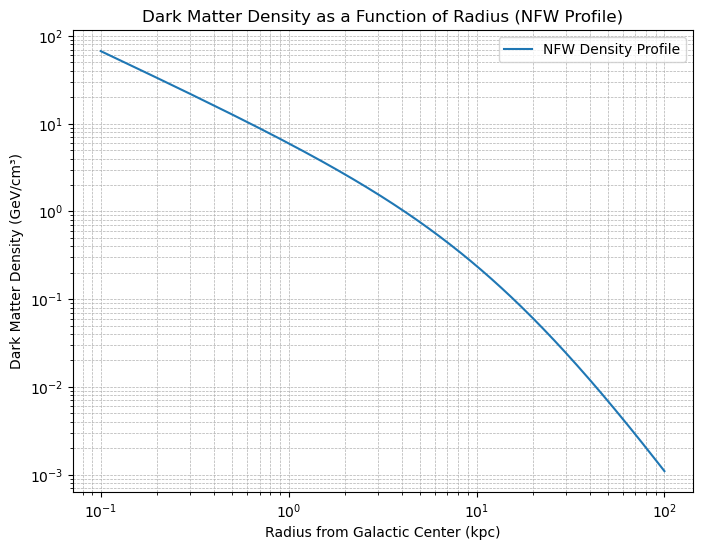

In [5]:
rho_s = 0.47  # Scale density in GeV/cm^3 of Milky Way 
r_s = 14.5  # Scale radius in kpc of Milky Way

# Function to compute the density at a given radius using NFW profile
def nfw_density(r, rho_s, r_s):
    return rho_s / ((r / r_s) * (1 + r / r_s)**2)

radii = np.linspace(0.1, 100, 1000) 

#corresponding density values
density_values = nfw_density(radii, rho_s, r_s)

# density as a function of radius
plt.figure(figsize=(8, 6))
plt.plot(radii, density_values, label="NFW Density Profile")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Radius from Galactic Center (kpc)")
plt.ylabel("Dark Matter Density (GeV/cm³)")
plt.title("Dark Matter Density as a Function of Radius (NFW Profile)")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.show()

As the capture rate depends on the local DM density, I use the variation of the density throughout the galaxy to show how the capture rate of a neutron star depends on its location in the galaxy. We can see that the capture rate follows the same function as dark matter throughout the galaxy.

In [6]:
v_esc = 1.8e+5 #km/s
v_disp = 220 #km/s
n_tot = 1.7e+57 #km/s
cs_XB = np.linspace(1e-45, 1e-47, num=1000)
m_X = np.linspace(1, 9.4e+5, num=1000) #GeV
T_core = 1e+6

cs_const = cs_XB[753]
mX_const = m_X[663]


DM_capture_1 = capture_rate(density_values, mX_const, v_esc, v_disp, cs_const, n_tot)


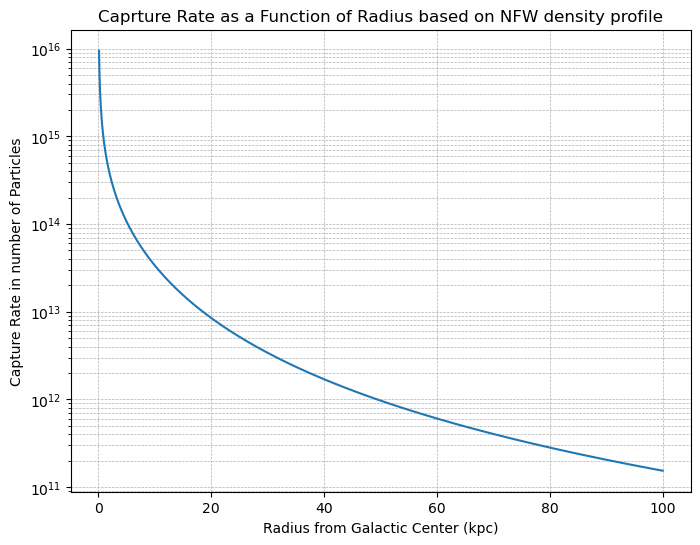

In [58]:
# Plot the capture rate as a function of radius
plt.figure(figsize=(8, 6))
plt.plot(radii, DM_capture_1)
plt.xscale("linear")
plt.yscale("log")
plt.xlabel("Radius from Galactic Center (kpc)")
plt.ylabel("Capture Rate in number of Particles")
plt.title("Caprture Rate as a Function of Radius based on NFW density profile")
plt.grid(True, which="both", ls="--", lw=0.5)
plt.show()

I assumed that a larger capture rate would cause the interaction rate between DM particles to increase inside the NS core and therefore cause the DM to collapse into a tiny black earlier than a smaller capture rate. 

Here I test this by taking the condition that for DM self-gravitation, the number of DM particles accumulated inside a NS must equal the number of particles needed for Jeans instability, and solving for the amount of time it takes for this to happen given the number of particles captured per second. 

We assume that collapse happens as soon as self-gravitation is reached. 

In order to see how the time to collapse depends on location within the galaxy, I solved for the time for each capture rate to find the time as a function of radii from the center of the galaxy.

In [8]:


def solve_for_t(t, rate, m_x, T_core):
    return DM_total(rate, t) - N_self(m_x, T_core)

t_self_grav = []

for capture in DM_capture_1:
    
    initial_guess = [1e17]
    
    t_solution = fsolve(solve_for_t, initial_guess, args=(capture, mX_const, T_core))
    t_self_grav.append(t_solution[0])



/srv/conda/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


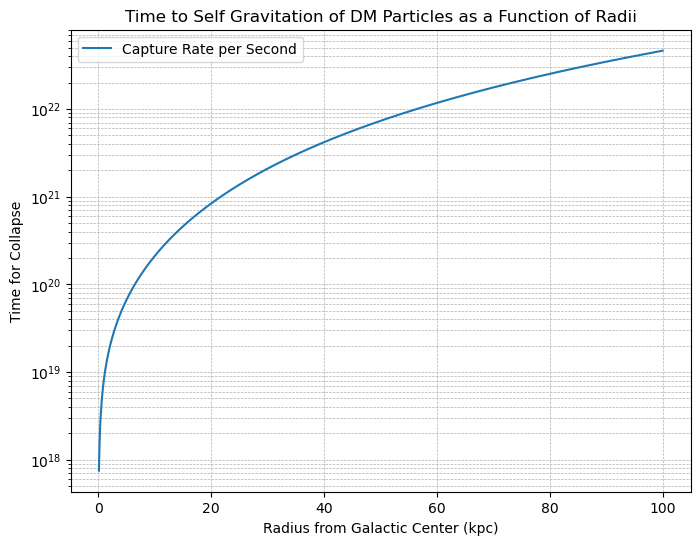

In [57]:

plt.figure(figsize=(8, 6))
plt.plot(radii, t_self_grav, label="Capture Rate per Second")
plt.xscale("linear")
plt.yscale("log")
plt.xlabel("Radius from Galactic Center (kpc)")
plt.ylabel("Time for Collapse")
plt.title("Time to Self Gravitation of DM Particles as a Function of Radii")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.show()


Thus we can see that Neutron Star Black Holes form at a much faster rate at the galactic center, and almost have a domino effect following out to the edge of the galaxy.




The following animation shows the neutron star to black hole formation out to the edge of the galaxy (14 kpc), which corresponds to 4.06e+20 seconds or about 13 trillion years. Crazy! Because the transmutation happens rapidly in the center of the galaxy where the DM density is the highest, at the edge of the galaxy it takes an eternity. By comparison, the time for collapse at the center of the galaxy is 7.5e+17 seconds. 


Make sure to take a look at all the simulation gifs (gifts) !:)

In [10]:
from IPython.display import HTML

HTML('<img src="TimeForFullConvertOutTo14Kpc.gif" width="1500"/>')

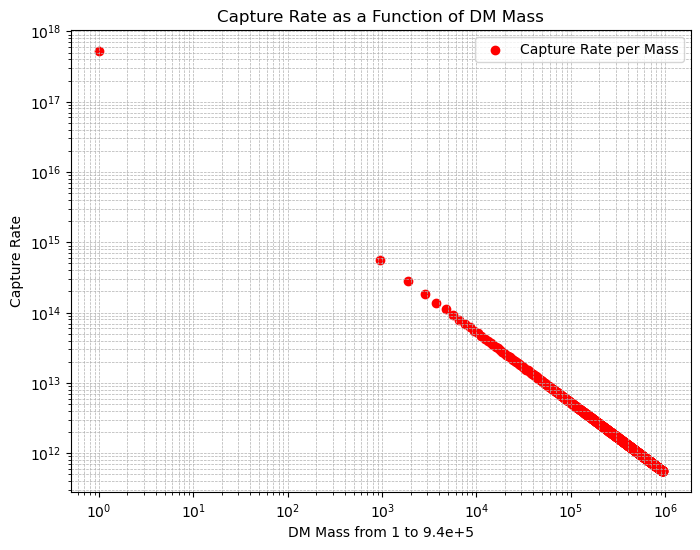

In [31]:
plt.figure(figsize=(8, 6))
plt.scatter(m_X, DM_capture_2, color='red', label="Capture Rate per Mass")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("DM Mass from 1 to 9.4e+5")
plt.ylabel("Capture Rate")
plt.title("Capture Rate as a Function of DM Mass")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.show()

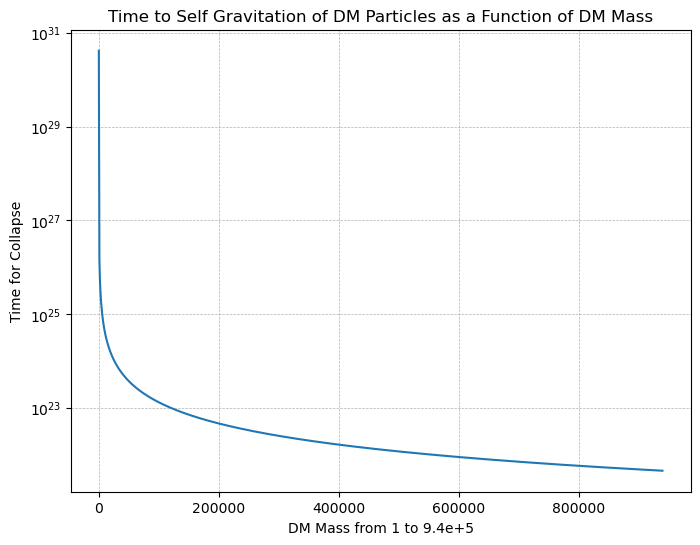

In [54]:

density_const = density_values[528]

#capture rate at constant local DM density, constant cross section
DM_capture_2 = capture_rate(density_const, m_X, v_esc, v_disp, cs_const, n_tot)

t_per_mass = []
initial_guess = np.linspace(1e+31, 1e+20, 1000)

for capture, m, init in zip(DM_capture_2, m_X, initial_guess):
    
    
    t_solution = fsolve(solve_for_t, init, args=(capture, m, T_core))
    t_per_mass.append(t_solution[0])

plt.figure(figsize=(8, 6))
plt.plot(m_X, t_per_mass)
plt.xscale("linear")
plt.yscale("log")
plt.xlabel("DM Mass from 1 to 9.4e+5")
plt.ylabel("Time for Collapse")
plt.title("Time to Self Gravitation of DM Particles as a Function of DM Mass")
plt.grid(True, which="both", ls="--", lw=0.5)
plt.show()


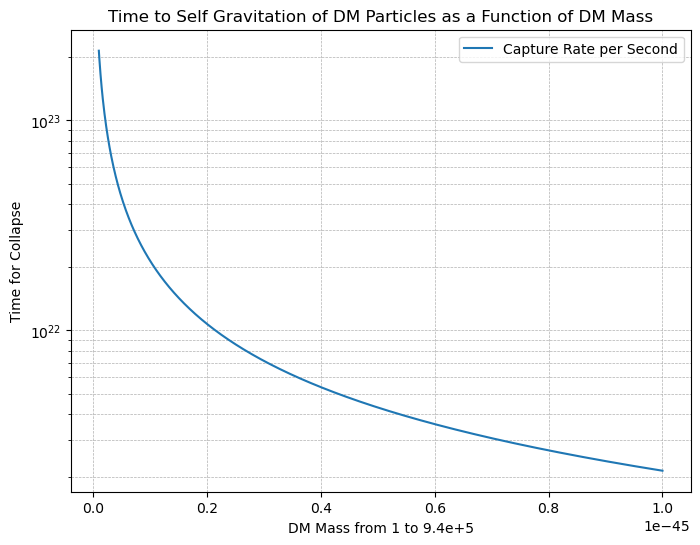

In [53]:

#capture rate at constant local DM density, constant mass
DM_capture_2 = capture_rate(density_const, mX_const, v_esc, v_disp, cs_XB, n_tot)

t_per_cs = []
initial_guess = np.linspace(1e+31, 1e+20, 1000)

for capture, init in zip(DM_capture_2, initial_guess):
    
    
    t_solution = fsolve(solve_for_t, init, args=(capture, mX_const, T_core))
    t_per_cs.append(t_solution[0])

plt.figure(figsize=(8, 6))
plt.plot(cs_XB, t_per_cs, label="Capture Rate per Second")
plt.xscale("linear")
plt.yscale("log")
plt.xlabel("DM Mass from 1 to 9.4e+5")
plt.ylabel("Time for Collapse")
plt.title("Time to Self Gravitation of DM Particles as a Function of DM Mass")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.show()
